# GSMM mixture modelling with real data

This notebook contains the following processing blocks:
- Gaussian mixture model
- Complex hierarchical gaussian filter
- Complex to real conversion
- Probabilistic Fourier transform
- Observation noise

## Import packages and functions

In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using FFTW
using Compat
using WAV
using DSP
using Base64
using ForneyLab
using LinearAlgebra
using ProgressMeter
using PyPlot
using GaussianMixtures
;

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


In [2]:
include("../extensions/ComplexNormal.jl")
include("../extensions/ComplexHGF.jl")
include("../extensions/ComplexToReal.jl")

include("../functions/auxiliary/workflow.jl") 
include("../functions/auxiliary/fourier.jl") 
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/preprocessing.jl") 
;

## Parameters

In [3]:
# data generation parameters
sound_file = "../data/woman.wav"      # specify sound location
fs = 8000                             # specify desired sampling frequency
normalization_method = "max"          # specify normalization method
nr_freqs = 19                         # number of frequencies (excluding DC and fs/2)
nr_clusters = 5                       # number of clusters (needs to be larger than 2 (ForneyLab issue))
bufsize = 2*(nr_freqs+1)              # number of samples in the buffer
stepsize = bufsize                    # step size inbetween buffers
nr_samples = Int(fs/bufsize)          # number of training samples
duration = 5                          # time of testing data

Σ_meas = 1e-10*Ic(bufsize)            # covariance matrix of measurement noise (over time in this case)
Σ_noise = 1e-2
;

## Load and process signals

In [4]:
# load speech data
x_speech, fs_speech = wavread(sound_file, format="native")
fs_speech = Int(fs_speech)
x_speech = convert(Array{Float64,1}, squeeze(x_speech[:,1]))[1*fs_speech:(1+duration)*fs_speech-1]

# pre-process signals
y_speech = preprocess(x_speech, fs_speech)[1:fs] # just 1 second!
y_speech_true = preprocess(x_speech, fs_speech)
y_speech_n = y_speech_true + sqrt(Σ_noise)*randn(size(y_speech_true))

# warp signal and take fft
f_speech = FFTovertime(y_speech, bufsize, bufsize-stepsize, rectangularwindow)
f_speech_n = FFTovertime(y_speech_n, bufsize, bufsize-stepsize, rectangularwindow)

# reduce fft 
fab_speech =  hcat(real.(f_speech[:,1]), 2*real.(f_speech[:,2:nr_freqs+1]), real.(f_speech[:,nr_freqs+2]), -real.(f_speech[:,1]), -2*imag.(f_speech[:,2:nr_freqs+1]), imag.(f_speech[:,nr_freqs+2]))
fab_speech_n =  hcat(real.(f_speech_n[:,1]), 2*real.(f_speech_n[:,2:nr_freqs+1]), real.(f_speech_n[:,nr_freqs+2]), -real.(f_speech_n[:,1]), -2*imag.(f_speech_n[:,2:nr_freqs+1]), imag.(f_speech_n[:,nr_freqs+2]))

# determine corresponding fft frequencies 
fi = abs.(FFTW.fftfreq(bufsize)[1:nr_freqs+2]*fs)[2:end-1]

# get the log abs values
z_speech = log.(abs2.(fab_speech[:,1:nr_freqs+2]) + abs2.(fab_speech[:,nr_freqs+3:end]))
z_speech_n = log.(abs2.(fab_speech_n[:,1:nr_freqs+2]) + abs2.(fab_speech_n[:,nr_freqs+3:end]))

# create time axis
t = collect(0:length(y_speech_n)-1)/fs

# create audioplayers for signals
audioplayers(y_speech, y_speech_n, fs=fs)
;

<source src="data:audio/wav;base64,UklGRjx9AABXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB9AAAtgQm+mdpevuqHLb784A2+HAnVvfu9cL3OJj49I9ADPs5eWj5KxJc+b2m6PnjRtz5OIrI+jaGVPp3i6T2k2te8S9wXvbB9nb1UzXO+EyCQvjqJLb4oopS9N8eRvUyiC71LCBY90cGjPUIFNT0z4p4767phvfVWq70zK9e9VI0RvpMRSb6uSka+aHEQvjsiz71hGqy9yX6PvIH/3z1kO10+n0yLPjLPqT5v/r0+zZ+8PlgHoT4LbRQ+hkHou0MDJL3JGJG9/49vvhclnL5cTFm+/jiuvVDdpb3/1469AfguPPZ6sz2ayI893XgaPVQembvC9Ta9uxvAvfFJ+r2y3zG+awZNvuuwL74wvAG+OV++vfL2Kby0iwU+HD18PiglmT558LY+i9fOPmthwj4EkVc+/XkePUXYDjxnAxK9FPdVvjsvr77PeYW+UPIPviDJA77M9g2+mQ8Tvchaxj0on/M9njhlPezLgzzwNAU9eIOePHi0pr31KzK+Xa87vh3RHL5yCRm+eicSvsYNl73W34c9ZXBCPuzthD6waJg+GmO9Pv59yD7L5pM+1yWxPekDZzltrqo7lezavbgMnr5JxKa+ootJvrVvF767Fi++AxvovQ2Z1zttj5E9AX6MPZ3qFD1CnwU8OAhpPMLiRzzpCKO9IkEhvosA772otjK97PFBvU9VT7thVyg+LkWgPhjMqj4M6K8+v4iYPhAmGz7iFZ49GtZJPebE7r3lXpm+gTKHvnGrN75pGFO+vXxhvlTExr0iUxc9N+GtPaKl4D1Vd+09qL+VPRP7gD2Sl3I9clsYvctKOL7vmT2+qCH/vWx/K77QMGG+2e4Avp6RRDxzBG097m+xPdjUMD5SEHk+YkJ6PvCUSj7KNyg+OTryPch0ij0viwq8W4dhvWW1bL21/Km9hIQdvo2bG77Qab+9zLezva9H3r09tXO9HDk3POdZN7puRSm9Ew87vTHa3rw61be8Dp6pvJVML7ukvVE9sTwRPugKZD6p7Ik+4e6hPmr0sz45ClM+2cYyPKtg0jtSYao8m6M/vl8DtL7Lp2e+MjbSvTKfO77JU1O+/GPFvEKh/T0E/fQ9CDDSPa8vIz4QvD0+Vc0aPk8Phj1FE5q8iE6ivUF1v73E7gG+VPw+vubNPr73GN29TE9rvVdbf72lbAG9gk4SPduKkT1Bmzk9/U0PPdBjGz1IWO48PmiXvKZ3UL1tjzO9z2bkvCwaDL1gJCG9wgoIveOQcbwn4ck7xNEBPEjBQ7s52QK7oJpkPKJ9bDt7R7i8MAgRvd4KX7wN7Va89XmhvJqDOjunAPY87eIKPWcGGj3ITFc9x2R8PfYaez1b+y09gB3yPMbZpTzcrXI8/QSBvDjtM71pbz+9/KNCvYfJi72m+Zi9G5FjvTRSS708GVK9nWAnvei8sLxjF6O8H6BRvDZmGzoqGUs8mgaePMm/Nj2HxoE9l9aCPY3vmj1m6809IQPHPWUWoj2JQGg9atspPboFiDzGALq8giCDvZmz0b3OGvC961HxvXwMAL5xzQy+G0PfvYx3mb2SDnK980MwvXcLSrwWDB48sg/hPGYSMD2Sq1U9lvqVPTv87j0vJhY+lgIuPrCPPz4CATM+vnzuPXuJmz393ig95tduvSJwD76sMR++iLwivnePWr7r52K+kFgivi8C572K/t69U5KYvQOky7s8AuU8T8gaPS84eT1cPME94CPiPQVz+T1xbh8+D/1JPt19aj7OsVo+WCLYPS3B0TwBZEk9/raVPDjeC75TP0a+SPC5vfObwb2jBEa+Uz8dvnkcnbyE6x68m0c4vW8iAT0nqds9Tc2kPSlGPj0eKJQ9lLeCPS0Un7uMcSS9U+IBvdOWZ71bz8C9VEy+vS5Ppr2UQ5m9PA+AvQ3aJ70npZO8Vrc/vKTda7x+/sG7LQAhPEqhbTyGwu+78YOOu/MqJDx/2io6y+V3vM/5zTou03M7Uu9vvMcFkrzdGSu8ogMbvMAe/rsRig66qfnWOyse2TtSHjI8ApYXPAiswDyMnh89pSH5PB+DijxgdME8etgHPYgKojxx1ok8RwjNPKjViTxrAJg6WN/TOXrhRruMUhC8kDoKvL74F7wPvOy7hosfvF2Lg7t31266dN/XukQuxzsFmtE7tWblOztRojzxhpk8JcAXPHJ3vTzNYOI8Ty0rPKii8ztNz8o8Av3FPLRvJTzjMwk8osdEO7JHmjrGT408+A+xO6umerwo2NA6/imHPJh6Wro+dbu7gir5O7oBpDqTK6w7OOgdPFy1IDuCgRY7zgZPPMY5czyrVBA7UtgJPARuQjyykzI8s9+3PIgixro4LIo8ixTpPHTPyDvdnKI8lqyUPMjzj7t0HWA8E1m7PAcZsbsb54e8BZMUO7wiEbxr5Tu8kDqHO3D89bt19x6714AnPPv1zrzcSC+8dVcIPd0JHDzTUBe9PLGbvAKMFj0H/Mo7bt0wvSL5dzxpC6s8ANo6vS3cGDxRqgk916EuvcLTFL0ZQOU84CgavDplOb3ISb68cOBTOkyMzLxT11a8/kR6vCOz5LyWFO07H1dXPLoyPL3J25O80wfmPJYTlbykCvu8BVxUO0CvS7o6i5+8iRSSvBcSvTsUOUO8sDznvD0pSrxUnYi76stzvMg+67y2lk+85zQfvNskXbw4ngu8bU+huxEPbbqybjy70xVau39eELsJBoQ7KTFZuiBD7rus8pi60RnJun9oMrrNEfa7xYjluy+9qrtAil67tOrKOi4Vijp3odS46MhTO+Sfszsxm4W7Ho5Vu3qyZLsK7A684q8qvMaRHLzTxQG8GERivKouZ7yV1RG8YZZ7u0Wd+boPcV+7EIPNO5OaNTyLJdU74lKJOy+nBTzgWsg7JwUZO6fQZDv6Qpo6b1OOOUkeaTqYxXm6qNB+ukDdAbtLekQ5o0UnO+XBQrvSxsK7qUPIuzfABrxO6QC8BHYMvDqMk7sq7NO5DdZMO06pnjsJqKi5+C6POw1RDTy/yc87z2/euUxdDjvzD+w7oEoROy8CNrsN0mc7b9DVOy1NbzvdYom6MNKJO2McwTvBSvI7PFUIPAP1ODwXMjE8ybwnPArNLzzjEv47/e8BPGykAzwQ9h47hx6VO968wDvLGwY82fI2PIKI8DvhO+c7T70DPAyo5TsYm8g778rRO/qrMzw3EBs8+2GROyLa5ju/jQ48VnXpOxAxWzy3+3E8hW0sPHZxCTw7sjY8Y2O2Ow23dTt/abM7Bnhau0khsru8fvq75BCHu0oTq7uJcmC7DBJTO/sWYjvB+SE6XWz+OktJLjvRvSi6Xre5u+8c5rtyqiS83b0bvOP3RLw1EoK88GiNvNPUcrymQIm8VwWRvPoeSbzeE228V6yAvI7AhLx9CXq876qWvPv/n7zyLJy86h2xvGQIpbzu+KK8VC+ZvGiSsrxJh2e8uM5HvEU3ibw/CVa8d95RvFz0MLzbCHy8GSucvH20nLwMj5i84cVzvFJ4f7z8mHi8485wvL60aLzb14e86QmPvO5narzQvDC84YZ0vMygWbwpsxy8VUcRvHTEGbzC+He77af/u6r8Jryd/Om7SQt1u+2Yi7u5fmq7BcTWu1ReObvJAMW3gLwDu24/rjqi+Uc6yJEjO4fBWjtl5Xk6TjE8O160NjslvKu74dccuqDRbTpiyeE6YXGSOqgqcTsH8d07eouEO50qvjv+zys8ilgFPHjzRTxUpGY86SQgPAU2OTwNQwU8UPYxPBg7EDx2kho8OZs/PJL/6jsqY+o7ExwbPFoIWTyZoxY8Js42PJZ2cTznyS48fdwIPGmOTDypE2c8a4yDPPdmeDyNL208nHliPICEkzyubYc8Qo0+PB/6OTwSD

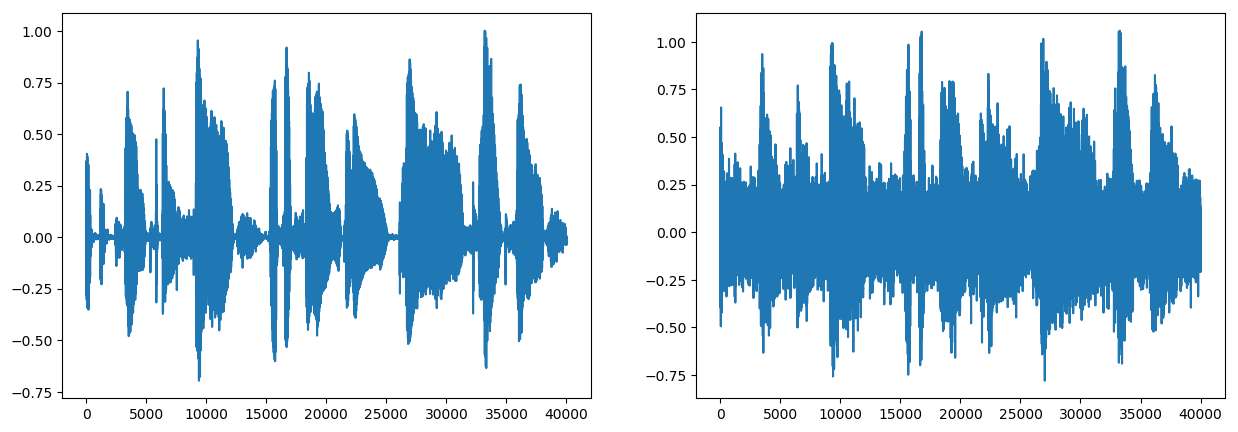

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000612A3710>

In [5]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(y_speech_true)
ax[2].plot(y_speech_n)

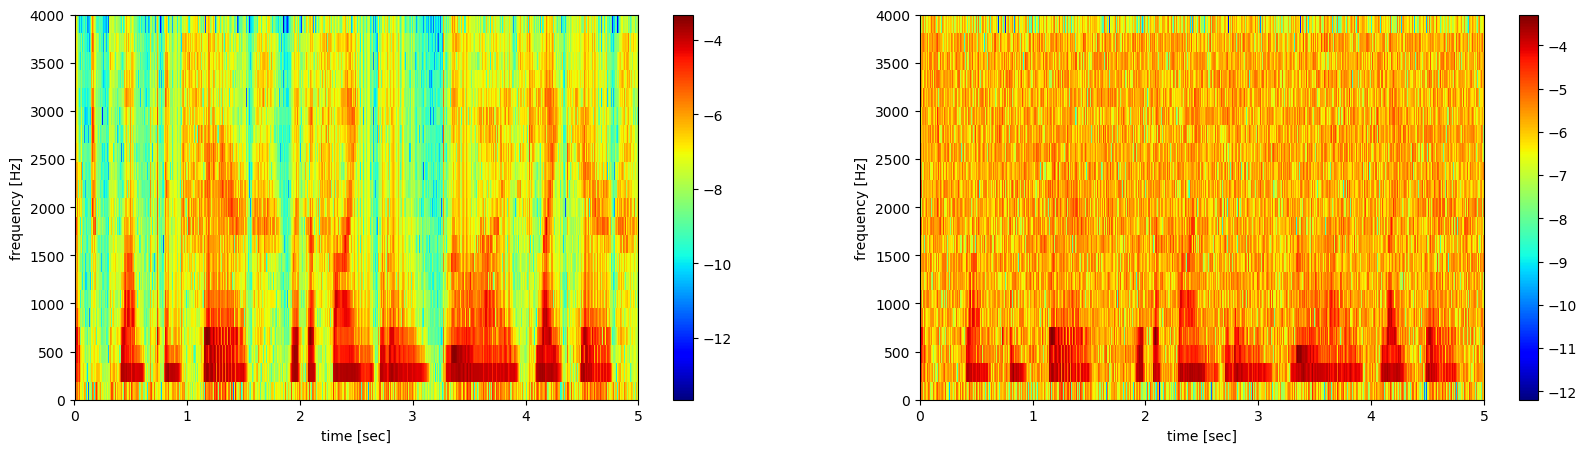

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(20,5))
plot_spectrogram(spectrogram(y_speech_true, bufsize, bufsize-stepsize, fs=fs), fs, ax=ax[1], colorbar=true)
plot_spectrogram(spectrogram(y_speech_n, bufsize, bufsize-stepsize, fs=fs), fs, ax=ax[2], colorbar=true)
;

## Train GSMM through K-means and EM

In [7]:
# perform clustering (ignore DC and fs/2)
g = GMM(nr_clusters, z_speech[:,2:end-1], nIter=50, nInit=100, kind=:diag)
em!(g, z_speech[:,2:end-1])
;

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.559636e+04
      1       1.030472e+04      -5.291634e+03 |        5
      2       9.474065e+03      -8.306569e+02 |        4
      3       9.084187e+03      -3.898786e+02 |        3
      4       8.840552e+03      -2.436345e+02 |        4
      5       8.821911e+03      -1.864155e+01 |        2
      6       8.817820e+03      -4.090594e+00 |        0
      7       8.817820e+03       0.000000e+00 |        0
K-means converged with 7 iterations (objv = 8817.819950996212)


┌ Info: Initializing GMM, 5 Gaussians diag covariance 19 dimensions using 200 data points
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 200 data points using 7 iterations
│ 2.0 data points per parameter
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\train.jl:139


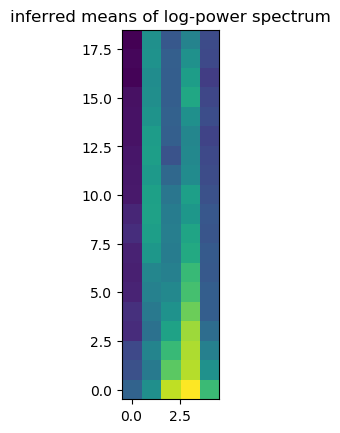

In [8]:
plt.imshow(g.μ', origin="lower")
plt.title("inferred means of log-power spectrum");

## Train GSMM through variational message passing on a factor graph

### Step 1: Build factor graph

In [9]:
# create factor graph
fg = FactorGraph()

# create distionary for variables
vars = Dict()

# specify distribution over the selection variables
@RV vars[:π] ~ ForneyLab.Dirichlet(placeholder(:α_π, dims=(nr_clusters,)))

# create mixture components
for k = 1:nr_clusters
    
    # specify distribution over precision matrix
    @RV vars[pad(:w,k)] ~ Wishart(placeholder(pad(:V_w,k), dims=(nr_freqs,nr_freqs)), placeholder(pad(:nu_w,k)))
    
    # specify distribution over mean
    @RV vars[pad(:m,k)] ~ GaussianMeanPrecision(placeholder(pad(:μ_m,k), dims=(nr_freqs,)), vars[pad(:w,k)])
    
end

# specify distribution over selection variable
@RV vars[:z] ~ Categorical(vars[:π])

# create gaussian mixture model
@RV vars[:ξ] ~ GaussianMixture(vars[:z], expand([[vars[pad(:m,ki)], vars[pad(:w,ki)]] for ki=1:nr_clusters])...)

# log-power to complex fourier coefficients transform
@RV vars[:Xc] ~ ComplexHGF(vars[:ξ])

# complex fourier coefficients to real and imaginary parts concatenated
@RV vars[:Xr] ~ ComplexToReal(vars[:Xc])

# probabilistic Fourier transform
@RV vars[:x] = placeholder(:C, dims=(bufsize, 2*(nr_freqs)))*vars[:Xr]

# observation model 
@RV vars[:y] ~ GaussianMeanVariance(vars[:x], Σ_meas)

# observation
placeholder(vars[:y], :y, dims=(bufsize,))

# draw graph
ForneyLab.draw(fg)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 9543908397394929815 -->
 9543908397394929815 
 
 = 
 equ_vars_w_02_1 
 
<!-- 702923867425779983 -->
 702923867425779983 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 9543908397394929815--702923867425779983 -->
 9543908397394929815--702923867425779983 
 
 vars_w_02 
 3 w 
 2 2 
 
<!-- 15468448450657532645 -->
 15468448450657532645 
 
 W 
 wishart_2 
 
<!-- 9543908397394929815--15468448450657532645 -->
 9543908397394929815--15468448450657532645 
 
 vars_w_02 
 1 out 
 1 1 
 
<!-- 14217115185951692851 -->
 14217115185951692851 
 
 GM 
 gaussianmixture_1 
 
<!-- 9543908397394929815--14217115185951692851 -->
 9543908397394929815--14217115185951692851 
 
 vars_w_02 
 6 w2 
 3 3 
 
<!-- 17586256923716975285 -->
 17586256923716975285 
 
 = 
 equ_vars_w_01_1 
 
<!-- 5709855930787523836 -->
 5709855930787523836 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 17586256923716975285--5709855930787523836 -->
 17586256923716975285--5709855930787523836 
 
 vars_w_01 
 3 w 
 2 2 
 
<!-- 17586256923716975285--14217115185951692851 -->
 17586256923716975285--14217115185951692851 
 
 vars_w_01 
 4 w1 
 3 3 
 
<!-- 15952673045389389413 -->
 15952673045389389413 
 
 W 
 wishart_1 
 
<!-- 17586256923716975285--15952673045389389413 -->
 17586256923716975285--15952673045389389413 
 
 vars_w_01 
 1 out 
 1 1 
 
<!-- 7173865253171183224 -->
 7173865253171183224 
 
 placeholder_μ_m_02 
 
<!-- 702923867425779983--7173865253171183224 -->
 702923867425779983--7173865253171183224 
 
 μ_m_02 
 1 out 
 2 m 
 
<!-- 17839467081545938795 -->
 17839467081545938795 
 
 placeholder_V_w_02 
 
<!-- 12358009312216537207 -->
 12358009312216537207 
 
 placeholder_V_w_04 
 
<!-- 15468448450657532645--17839467081545938795 -->
 15468448450657532645--17839467081545938795 
 
 V_w_02 
 1 out 
 2 v 
 
<!-- 7092008122126222107 -->
 7092008122126222107 
 
 placeholder_nu_w_02 
 
<!-- 15468448450657532645--7092008122126222107 -->
 15468448450657532645--7092008122126222107 
 
 nu_w_02 
 1 out 
 3 nu 
 
<!-- 6053955463632669244 -->
 6053955463632669244 
 
 Dir 
 dirichlet_1 
 
<!-- 14322209509548414403 -->
 14322209509548414403 
 
 placeholder_α_π 
 
<!-- 6053955463632669244--14322209509548414403 -->
 6053955463632669244--14322209509548414403 
 
 α_π 
 1 out 
 2 a 
 
<!-- 18293907798147533056 -->
 18293907798147533056 
 
 placeholder_μ_m_05 
 
<!-- 5811859256627709024 -->
 5811859256627709024 
 
 W 
 wishart_3 
 
<!-- 11555645017915983797 -->
 11555645017915983797 
 
 placeholder_V_w_03 
 
<!-- 5811859256627709024--11555645017915983797 -->
 5811859256627709024--11555645017915983797 
 
 V_w_03 
 1 out 
 2 v 
 
<!-- 11974529944379696271 -->
 11974529944379696271 
 
 placeholder_nu_w_03 
 
<!-- 5811859256627709024--11974529944379696271 -->
 5811859256627709024--11974529944379696271 
 
 nu_w_03 
 1 out 
 3 nu 
 
<!-- 13515026536790122467 -->
 13515026536790122467 
 
 ComplexToReal 
 complextoreal_1 
 
<!-- 5678583499433540700 -->
 5678583499433540700 
 
 ComplexHGF 
 complexhgf_1 
 
<!-- 13515026536790122467--5678583499433540700 -->
 13515026536790122467--5678583499433540700 
 
 vars_Xc 
 1 X 
 2 cx 
 
<!-- 3874782216668791131 -->
 3874782216668791131 
 
 placeholder_nu_w_01 
 
<!-- 4227564412999386344 -->
 4227564412999386344 
 
 Cat 
 categorical_1 
 
<!-- 4227564412999386344--6053955463632669244 -->
 4227564412999386344--6053955463632669244 
 
 vars_π 
 1 out 
 2 p 
 
<!-- 16730614570739681077 -->
 16730614570739681077 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 183061967080830576 -->
 183061967080830576 
 
 placeholde

### Step 2: Generate inference algorithm

In [10]:
# specify ids for the posterior factorization
q_ids = vcat(:Π,
              expand([[pad(:M,k), pad(:W,k)] for k=1:nr_clusters]),
              :Z, :Xc, :Ξ)

# specify posterior factorization
q = PosteriorFactorization(vars[:π], 
                           expand([[vars[pad(:m,k)], vars[pad(:w,k)]] for k=1:nr_clusters])...,
                           vars[:z], vars[:Xc], vars[:ξ],
                           ids=q_ids)

# generate the inference algorithm
algo = variationalAlgorithm(q)

# Generate source code
source_code = algorithmSourceCode(algo)

# Load algorithm
eval(Meta.parse(source_code))
;

### Step 3: create data and marginals dictionary

In [11]:
y_samples = [y_speech[(k-1)*bufsize+1:k*bufsize] for k = 1:Int(length(y_speech)/bufsize)];
y_samples_n = [y_speech_n[(k-1)*bufsize+1:k*bufsize] for k = 1:Int(length(y_speech_n)/bufsize)];
t_samples = [t[(k-1)*bufsize+1:k*bufsize] for k = 1:Int(length(t)/bufsize)];
;

### Step 4: Perform inference

In [12]:
# set number of iterations
nr_its = 20

# placeholders for priors
μ_m_min = Array{Array{Float64,1},1}(undef, nr_clusters)
nu_w_min = Array{Float64,1}(undef, nr_clusters)
V_w_min = Array{Array{Float64,2},1}(undef, nr_clusters)

# set priors (and current values later on)
α_π_min = ones(nr_clusters)
for k = 1:nr_clusters
    μ_m_min[k] = g.μ[k,:]
    nu_w_min[k] = nr_freqs
    V_w_min[k] = diagm(1 ./g.Σ[k,:]) / nr_freqs
end

# memory placeholders
z_mem = Array{Int64,1}(undef, nr_samples)

# create progress bar
p = Progress(nr_samples)

# perform iterations
for i = 1:nr_samples
    
    # create data dictionary
    data = Dict()
    data[:y] = y_samples[i]
    data[:α_π] = α_π_min
    for k = 1:nr_clusters
        data[pad(:μ_m,k)] = μ_m_min[k]
        data[pad(:nu_w,k)] = nu_w_min[k]
        data[pad(:V_w,k)] = V_w_min[k]
    end
    data[:C] = 1/bufsize*hcat(cos.(2*pi*fi*t_samples[i]')', sin.(2*pi*fi*t_samples[i]')')
    
    # create marginals dictionary
    marginals = Dict()
    marginals[:vars_π] = ProbabilityDistribution(ForneyLab.Dirichlet, a=α_π_min)
    for k = 1:nr_clusters
        marginals[pad(:vars_m,k)] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=data[pad(:μ_m,k)], w=data[pad(:V_w,k)]*data[pad(:nu_w,k)])
        marginals[pad(:vars_w,k)] = ProbabilityDistribution(MatrixVariate, ForneyLab.Wishart, v=data[pad(:V_w,k)], nu=data[pad(:nu_w,k)])
    end
    marginals[:vars_z] = vague(Categorical)
    marginals[:vars_Xc] = ProbabilityDistribution(Multivariate, ComplexNormal, μ=zeros(nr_freqs) .+ 0.0im, Γ=1e10*Ic(nr_freqs).+0.0im, C=mat(0.0+0.0im))
    marginals[:vars_ξ] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=zeros(nr_freqs), v=1*Ic(nr_freqs))
    
    for _ = 1:nr_its
        # perform updates
        stepXc!(data, marginals)
        stepΞ!(data, marginals)
        stepZ!(data, marginals)
        stepΠ!(data, marginals) 
        for k = 1:nr_clusters
            getfield(Main, Symbol("stepM_"*string(k,pad=2)*"!"))(data, marginals)
            getfield(Main, Symbol("stepW_"*string(k,pad=2)*"!"))(data, marginals)
        end
    end
    
    # extract parameters and update beliefs
    α_π_min = marginals[:vars_π].params[:a]
    for k = 1:nr_clusters
        μ_m_min[k] = ForneyLab.unsafeMean(marginals[pad(:vars_m,k)])
        nu_w_min[k] = marginals[pad(:vars_w,k)].params[:nu]
        V_w_min[k] = marginals[pad(:vars_w,k)].params[:v]
    end
    z_mem[i] = findmax(marginals[:vars_z].params[:p])[2]
    
    # update progress bar
    next!(p)
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


### Step 5: Analyze results

In [13]:
# get inferred cluster assignments and print confusion matrix
z_train_em = [findmax(llpg(g, z_speech[:,2:end-1])[k,:])[2] for k = 1:g.nx];
z_train_inf = z_mem

# get clusters with zero assignments
remaining_clusters = unique(z_train_inf)
rm_clusters = length(remaining_clusters)

# plot confusion matrix
confusionmatrix(nr_clusters, z_train_em .- minimum(z_train_em) .+ 1, z_train_inf .- minimum(z_train_inf) .+ 1)

5×5 Array{Int64,2}:
 4   0   0  0  46
 0  10   0  0  15
 0   2   4  0  31
 0   8  22  1   1
 0   0   0  0  56

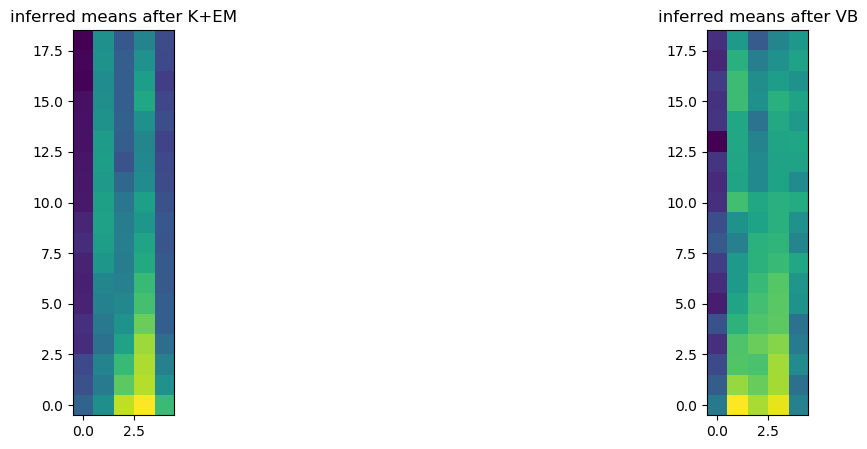

PyObject Text(0.5, 1.0, 'inferred means after VB')

In [14]:
# get new means and variances of remaining clustersand show results
μ_trained = []
V_trained = []
nu_trained = []
α_π_trained = []
for k = 1:nr_clusters
    if k in remaining_clusters
        push!(μ_trained, μ_m_min[k])
        push!(V_trained, V_w_min[k])
        push!(nu_trained, nu_w_min[k])
        push!(α_π_trained, α_π_min[k])
    end
end

# plot new and previous means
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].imshow(g.μ', origin="lower")
ax[1].set_title("inferred means after K+EM")
ax[2].imshow(hcat(μ_trained...), origin="lower")
ax[2].set_title("inferred means after VB")


## Perform speech enhancement

### Step 1: build factor graph

In [15]:
# create factor graph
fg = FactorGraph()

# create distionary for variables
vars_e = Dict()

# specify distribution over the selection variables
@RV vars_e[:π] ~ ForneyLab.Dirichlet(placeholder(:α_π, dims=(rm_clusters,)))

# create mixture components
for k = 1:rm_clusters
    
    # specify distribution over precision matrix
    @RV vars_e[pad(:w,k)] ~ Wishart(placeholder(pad(:V_w,k), dims=(nr_freqs,nr_freqs)), placeholder(pad(:nu_w,k)))
    
    # specify distribution over mean
    @RV vars_e[pad(:m,k)] ~ GaussianMeanPrecision(placeholder(pad(:μ_m,k), dims=(nr_freqs,)), vars_e[pad(:w,k)])
    
end

# specify distribution over selection variable
@RV vars_e[:z] ~ Categorical(vars_e[:π])

# create gaussian mixture model
@RV vars_e[:ξ] ~ GaussianMixture(vars_e[:z], expand([[vars_e[pad(:m,ki)], vars_e[pad(:w,ki)]] for ki=1:rm_clusters])...)

# log-power to complex fourier coefficients transform
@RV vars_e[:Xc] ~ ComplexHGF(vars_e[:ξ])

# complex fourier coefficients to real and imaginary parts concatenated
@RV vars_e[:Xr] ~ ComplexToReal(vars_e[:Xc])

# probabilistic Fourier transform
@RV vars_e[:x] = placeholder(:C, dims=(bufsize, 2*(nr_freqs)))*vars_e[:Xr]

# observation model 
@RV vars_e[:y] ~ GaussianMeanVariance(vars_e[:x], Σ_noise*Ic(bufsize))

# observation
placeholder(vars_e[:y], :y, dims=(bufsize,))
   
# draw graph
ForneyLab.draw(fg)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 9152480818924318831 -->
 9152480818924318831 
 
 placeholder_V_w_02 
 
<!-- 11068872352382915803 -->
 11068872352382915803 
 
 W 
 wishart_4 
 
<!-- 5347917667299441009 -->
 5347917667299441009 
 
 placeholder_nu_w_04 
 
<!-- 11068872352382915803--5347917667299441009 -->
 11068872352382915803--5347917667299441009 
 
 nu_w_04 
 1 out 
 3 nu 
 
<!-- 1139225292969812117 -->
 1139225292969812117 
 
 placeholder_V_w_04 
 
<!-- 11068872352382915803--1139225292969812117 -->
 11068872352382915803--1139225292969812117 
 
 V_w_04 
 1 out 
 2 v 
 
<!-- 1082297298875366126 -->
 1082297298875366126 
 
 placeholder_μ_m_05 
 
<!-- 746834323309597385 -->
 746834323309597385 
 
 = 
 equ_vars_e_w_05_1 
 
<!-- 10274512507030776415 -->
 10274512507030776415 
 
 𝒩 
 gaussianmeanprecision_5 
 
<!-- 746834323309597385--10274512507030776415 -->
 746834323309597385--10274512507030776415 
 
 vars_e_w_05 
 3 w 
 2 2 
 
<!-- 473418715163888737 -->
 473418715163888737 
 
 GM 
 gaussianmixture_1 
 
<!-- 746834323309597385--473418715163888737 -->
 746834323309597385--473418715163888737 
 
 vars_e_w_05 
 12 w5 
 3 3 
 
<!-- 14642920369982269547 -->
 14642920369982269547 
 
 W 
 wishart_5 
 
<!-- 746834323309597385--14642920369982269547 -->
 746834323309597385--14642920369982269547 
 
 vars_e_w_05 
 1 out 
 1 1 
 
<!-- 8110233326037385498 -->
 8110233326037385498 
 
 placeholder_V_w_05 
 
<!-- 15866090845486826725 -->
 15866090845486826725 
 
 placeholder_μ_m_04 
 
<!-- 10274512507030776415--1082297298875366126 -->
 10274512507030776415--1082297298875366126 
 
 μ_m_05 
 1 out 
 2 m 
 
<!-- 11217971908056990166 -->
 11217971908056990166 
 
 Cat 
 categorical_1 
 
<!-- 11772812608246552766 -->
 11772812608246552766 
 
 Dir 
 dirichlet_1 
 
<!-- 11217971908056990166--11772812608246552766 -->
 11217971908056990166--11772812608246552766 
 
 vars_e_π 
 1 out 
 2 p 
 
<!-- 14388650912059448544 -->
 14388650912059448544 
 
 placeholder_nu_w_03 
 
<!-- 8121166416476400595 -->
 8121166416476400595 
 
 placeholder_α_π 
 
<!-- 11772812608246552766--8121166416476400595 -->
 11772812608246552766--8121166416476400595 
 
 α_π 
 1 out 
 2 a 
 
<!-- 15823296319663404031 -->
 15823296319663404031 
 
 × 
 multiplication_1 
 
<!-- 17602005220234809779 -->
 17602005220234809779 
 
 ComplexToReal 
 complextoreal_1 
 
<!-- 15823296319663404031--17602005220234809779 -->
 15823296319663404031--17602005220234809779 
 
 vars_e_Xr 
 1 rx 
 2 in1 
 
<!-- 9965830546476020636 -->
 9965830546476020636 
 
 placeholder_C 
 
<!-- 15823296319663404031--9965830546476020636 -->
 15823296319663404031--9965830546476020636 
 
 C 
 1 out 
 3 a 
 
<!-- 3727113909508547065 -->
 3727113909508547065 
 
 = 
 equ_vars_e_w_02_1 
 
<!-- 3727113909508547065--473418715163888737 -->
 3727113909508547065--473418715163888737 
 
 vars_e_w_02 
 6 w2 
 3 3 
 
<!-- 2670413308404113799 -->
 2670413308404113799 
 
 W 
 wishart_2 
 
<!-- 3727113909508547065--2670413308404113799 -->
 3727113909508547065--2670413308404113799 
 
 vars_e_w_02 
 1 out 
 1 1 
 
<!-- 5216900113025545206 -->
 5216900113025545206 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 3727113909508547065--5216900113025545206 -->
 3727113909508547065--5216900113025545206 
 
 vars_e_w_02 
 3 w 
 2 2 
 
<!-- 9163673896737683970 -->
 9163673896737683970 
 
 = 
 equ_vars_e_w_01_1 
 
<!-- 9163673896737683970--473418715163888737 -->
 9163673896737683970--473418715163888737 
 
 vars_e_w_01 
 4 w1 
 3 3 
 
<!-- 12958116546369171074 -->
 12958116546369171074 
 
 𝒩 
 gaussianmeanprecisio

### Step 2: Generate inference algorithm

In [16]:
# specify ids for the posterior factorization
q_ids = vcat(:Π,
              expand([[pad(:M,k), pad(:W,k)] for k=1:rm_clusters]),
              :Z, :Xc, :Ξ)

# specify posterior factorization
q = PosteriorFactorization(vars_e[:π], 
                           expand([[vars_e[pad(:m,k)], vars_e[pad(:w,k)]] for k=1:rm_clusters])...,
                           vars_e[:z], vars_e[:Xc], vars_e[:ξ], ids=q_ids)

# generate the inference algorithm
algo = variationalAlgorithm(q)

# Generate source code
source_code = algorithmSourceCode(algo)

# Load algorithm
eval(Meta.parse(source_code))
;

### Step 3: inference

In [17]:
# prevent posdef errors (Marco his comment on ForneyLab issue #86)
function safeChol(A::Hermitian)
    # `safeChol(A)` is a 'safe' version of `chol(A)` in the sense
    # that it adds jitter to the diagonal of `A` and tries again if
    # `chol` raised a `PosDefException`.
    # Matrix `A` can be non-positive-definite in practice even though it
    # shouldn't be in theory due to finite floating point precision.
    # If adding jitter does not help, `PosDefException` will still be raised.
    L = similar(A)
    try
        L = cholesky(A)
        catch #Base.LinAlg.PosDefException
        # Add jitter to diagonal to break linear dependence among rows/columns.
        # The additive noise is input-dependent to make sure that we hit the
        # significant precision of the Float64 values with high probability.
        jitter = Diagonal(1e-13*(rand(size(A,1))) .* diag(A))
        L = cholesky(A + jitter)
    end
end
ForneyLab.unsafeMean(dist::ProbabilityDistribution{Multivariate, GaussianWeightedMeanPrecision}) = inv(safeChol(Hermitian(dist.params[:w])))*dist.params[:xi]
unsafeMean(dist::ProbabilityDistribution{Multivariate, GaussianWeightedMeanPrecision}) = inv(safeChol(Hermitian(dist.params[:w])))*dist.params[:xi]

unsafeMean (generic function with 16 methods)

In [18]:
# create placeholders
ξ_inferred = Array{Float64, 2}(undef, nr_samples*duration, nr_freqs)
x_inferred = Array{Float64, 2}(undef, nr_samples*duration, bufsize)

# loop through segments
@showprogress for k = 1:nr_samples*duration
    
    # set number of iterations
    nr_its = 10

    # create data dictionary
    data = Dict()

    # specify input data and measurement noise
    data[:y] = y_samples_n[k] .- mean(y_samples_n[k])

    # specify priors over class probabilities
    data[:α_π] = α_π_trained

    # specify priors over clusters
    for ki = 1:rm_clusters
        data[pad(:μ_m,ki)] = μ_trained[ki]
        data[pad(:nu_w,ki)] = nu_trained[ki]
        data[pad(:V_w,ki)] =  V_trained[ki]
    end

    # specify probabilistic fourier matrices
    data[:C] = 1/bufsize*hcat(cos.(2*pi*fi*t_samples[k]')', sin.(2*pi*fi*t_samples[k]')')
    

    # create marginals dictionary
    marginals = Dict()

    # specify marginals over class probabilities
    marginals[:vars_e_π] = ProbabilityDistribution(ForneyLab.Dirichlet, a=α_π_trained)

    # specify marginals over clusters
    for ki = 1:rm_clusters
        marginals[pad(:vars_e_m,ki)] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=data[pad(:μ_m,ki)], w=data[pad(:V_w,ki)]*data[pad(:nu_w,ki)])
        marginals[pad(:vars_e_w,ki)] = ProbabilityDistribution(MatrixVariate, ForneyLab.Wishart, v=data[pad(:V_w,ki)], nu=data[pad(:nu_w,ki)])
    end
    
    # specify marginals over samples
    #marginals[:vars_e_z] = vague(Categorical)
    #marginals[:vars_e_z] = ProbabilityDistribution(Categorical, p=ps/sum(ps))
    marginals[:vars_e_z] = ProbabilityDistribution(Categorical, p=exp.(α_π_trained)/sum(exp.(α_π_trained))) # not sure whether best way
    marginals[:vars_e_Xc] = ProbabilityDistribution(Multivariate, ComplexNormal, μ=zeros(nr_freqs) .+ 0.0im, Γ=(1e10)*Ic(nr_freqs).+0.0im, C=mat(0.0+0.0im))
    marginals[:vars_e_ξ] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=z_speech_n[k,2:end-1], v=1.0*diagm(squeeze(var(z_speech_n[:,2:end-1], dims=1))))
                    
    # perform iterations
    for i = 1:nr_its

        # perform updates
        stepXc!(data, marginals)
        stepΞ!(data, marginals)
        stepZ!(data, marginals)
        
    end
    try
        ξ_inferred[k,:] = ForneyLab.unsafeMean(marginals[:vars_e_ξ])
        x_inferred[k,:] = ForneyLab.unsafeMean(marginals[:vars_e_x]) .+ mean(y_samples_n[k])
    catch
        ξ_inferred[k,:] = zeros(nr_freqs)
        x_inferred[k,:] = zeros(bufsize)
        println("Posdef Exception, k="*string(k))
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:31


### Step 4: results

In [19]:
# reshape enhance speech signal
y_enhanced = vcat(x_inferred'...)
;

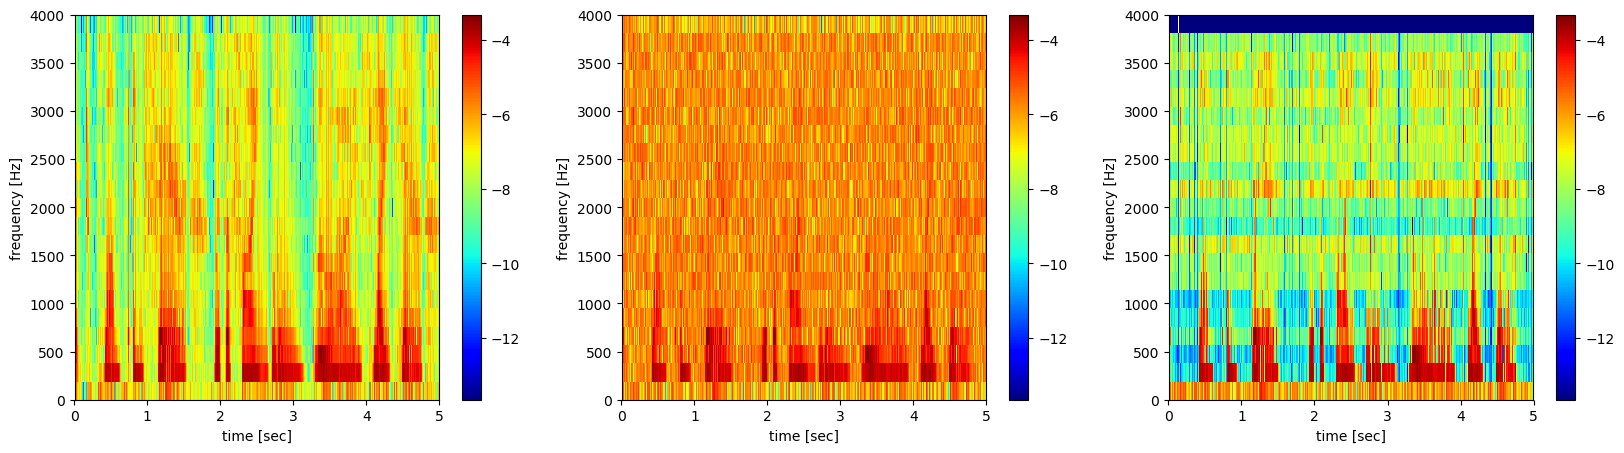

In [20]:
#plt.imshow(ξ_inferred',origin="lower", aspect="auto"), plt.colorbar()
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
cmp = plot_spectrogram(spectrogram(y_speech_true, bufsize, bufsize-stepsize, fs=fs), fs, ax=ax[1], colorbar=true)
plot_spectrogram(spectrogram(y_speech_n, bufsize, bufsize-stepsize, fs=fs), fs, ax=ax[2])
plot_spectrogram(spectrogram(y_enhanced, bufsize, bufsize-stepsize, fs=fs), fs, ax=ax[3])
vrange = ax[1].get_images()[1].get_clim()
fig.colorbar(cmp, ax=ax[2])
ax[2].get_images()[1].set_clim(vrange)
fig.colorbar(cmp, ax=ax[3])
ax[3].get_images()[1].set_clim(vrange)
;

<source src="data:audio/wav;base64,UklGRjxxAgBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQBxAgAtgQm+mdpevuqHLb784A2+HAnVvfu9cL3OJj49I9ADPs5eWj5KxJc+b2m6PnjRtz5OIrI+jaGVPp3i6T2k2te8S9wXvbB9nb1UzXO+EyCQvjqJLb4oopS9N8eRvUyiC71LCBY90cGjPUIFNT0z4p4767phvfVWq70zK9e9VI0RvpMRSb6uSka+aHEQvjsiz71hGqy9yX6PvIH/3z1kO10+n0yLPjLPqT5v/r0+zZ+8PlgHoT4LbRQ+hkHou0MDJL3JGJG9/49vvhclnL5cTFm+/jiuvVDdpb3/1469AfguPPZ6sz2ayI893XgaPVQembvC9Ta9uxvAvfFJ+r2y3zG+awZNvuuwL74wvAG+OV++vfL2Kby0iwU+HD18PiglmT558LY+i9fOPmthwj4EkVc+/XkePUXYDjxnAxK9FPdVvjsvr77PeYW+UPIPviDJA77M9g2+mQ8Tvchaxj0on/M9njhlPezLgzzwNAU9eIOePHi0pr31KzK+Xa87vh3RHL5yCRm+eicSvsYNl73W34c9ZXBCPuzthD6waJg+GmO9Pv59yD7L5pM+1yWxPekDZzltrqo7lezavbgMnr5JxKa+ootJvrVvF767Fi++AxvovQ2Z1zttj5E9AX6MPZ3qFD1CnwU8OAhpPMLiRzzpCKO9IkEhvosA772otjK97PFBvU9VT7thVyg+LkWgPhjMqj4M6K8+v4iYPhAmGz7iFZ49GtZJPebE7r3lXpm+gTKHvnGrN75pGFO+vXxhvlTExr0iUxc9N+GtPaKl4D1Vd+09qL+VPRP7gD2Sl3I9clsYvctKOL7vmT2+qCH/vWx/K77QMGG+2e4Avp6RRDxzBG097m+xPdjUMD5SEHk+YkJ6PvCUSj7KNyg+OTryPch0ij0viwq8W4dhvWW1bL21/Km9hIQdvo2bG77Qab+9zLezva9H3r09tXO9HDk3POdZN7puRSm9Ew87vTHa3rw61be8Dp6pvJVML7ukvVE9sTwRPugKZD6p7Ik+4e6hPmr0sz45ClM+2cYyPKtg0jtSYao8m6M/vl8DtL7Lp2e+MjbSvTKfO77JU1O+/GPFvEKh/T0E/fQ9CDDSPa8vIz4QvD0+Vc0aPk8Phj1FE5q8iE6ivUF1v73E7gG+VPw+vubNPr73GN29TE9rvVdbf72lbAG9gk4SPduKkT1Bmzk9/U0PPdBjGz1IWO48PmiXvKZ3UL1tjzO9z2bkvCwaDL1gJCG9wgoIveOQcbwn4ck7xNEBPEjBQ7s52QK7oJpkPKJ9bDt7R7i8MAgRvd4KX7wN7Va89XmhvJqDOjunAPY87eIKPWcGGj3ITFc9x2R8PfYaez1b+y09gB3yPMbZpTzcrXI8/QSBvDjtM71pbz+9/KNCvYfJi72m+Zi9G5FjvTRSS708GVK9nWAnvei8sLxjF6O8H6BRvDZmGzoqGUs8mgaePMm/Nj2HxoE9l9aCPY3vmj1m6809IQPHPWUWoj2JQGg9atspPboFiDzGALq8giCDvZmz0b3OGvC961HxvXwMAL5xzQy+G0PfvYx3mb2SDnK980MwvXcLSrwWDB48sg/hPGYSMD2Sq1U9lvqVPTv87j0vJhY+lgIuPrCPPz4CATM+vnzuPXuJmz393ig95tduvSJwD76sMR++iLwivnePWr7r52K+kFgivi8C572K/t69U5KYvQOky7s8AuU8T8gaPS84eT1cPME94CPiPQVz+T1xbh8+D/1JPt19aj7OsVo+WCLYPS3B0TwBZEk9/raVPDjeC75TP0a+SPC5vfObwb2jBEa+Uz8dvnkcnbyE6x68m0c4vW8iAT0nqds9Tc2kPSlGPj0eKJQ9lLeCPS0Un7uMcSS9U+IBvdOWZ71bz8C9VEy+vS5Ppr2UQ5m9PA+AvQ3aJ70npZO8Vrc/vKTda7x+/sG7LQAhPEqhbTyGwu+78YOOu/MqJDx/2io6y+V3vM/5zTou03M7Uu9vvMcFkrzdGSu8ogMbvMAe/rsRig66qfnWOyse2TtSHjI8ApYXPAiswDyMnh89pSH5PB+DijxgdME8etgHPYgKojxx1ok8RwjNPKjViTxrAJg6WN/TOXrhRruMUhC8kDoKvL74F7wPvOy7hosfvF2Lg7t31266dN/XukQuxzsFmtE7tWblOztRojzxhpk8JcAXPHJ3vTzNYOI8Ty0rPKii8ztNz8o8Av3FPLRvJTzjMwk8osdEO7JHmjrGT408+A+xO6umerwo2NA6/imHPJh6Wro+dbu7gir5O7oBpDqTK6w7OOgdPFy1IDuCgRY7zgZPPMY5czyrVBA7UtgJPARuQjyykzI8s9+3PIgixro4LIo8ixTpPHTPyDvdnKI8lqyUPMjzj7t0HWA8E1m7PAcZsbsb54e8BZMUO7wiEbxr5Tu8kDqHO3D89bt19x6714AnPPv1zrzcSC+8dVcIPd0JHDzTUBe9PLGbvAKMFj0H/Mo7bt0wvSL5dzxpC6s8ANo6vS3cGDxRqgk916EuvcLTFL0ZQOU84CgavDplOb3ISb68cOBTOkyMzLxT11a8/kR6vCOz5LyWFO07H1dXPLoyPL3J25O80wfmPJYTlbykCvu8BVxUO0CvS7o6i5+8iRSSvBcSvTsUOUO8sDznvD0pSrxUnYi76stzvMg+67y2lk+85zQfvNskXbw4ngu8bU+huxEPbbqybjy70xVau39eELsJBoQ7KTFZuiBD7rus8pi60RnJun9oMrrNEfa7xYjluy+9qrtAil67tOrKOi4Vijp3odS46MhTO+Sfszsxm4W7Ho5Vu3qyZLsK7A684q8qvMaRHLzTxQG8GERivKouZ7yV1RG8YZZ7u0Wd+boPcV+7EIPNO5OaNTyLJdU74lKJOy+nBTzgWsg7JwUZO6fQZDv6Qpo6b1OOOUkeaTqYxXm6qNB+ukDdAbtLekQ5o0UnO+XBQrvSxsK7qUPIuzfABrxO6QC8BHYMvDqMk7sq7NO5DdZMO06pnjsJqKi5+C6POw1RDTy/yc87z2/euUxdDjvzD+w7oEoROy8CNrsN0mc7b9DVOy1NbzvdYom6MNKJO2McwTvBSvI7PFUIPAP1ODwXMjE8ybwnPArNLzzjEv47/e8BPGykAzwQ9h47hx6VO968wDvLGwY82fI2PIKI8DvhO+c7T70DPAyo5TsYm8g778rRO/qrMzw3EBs8+2GROyLa5ju/jQ48VnXpOxAxWzy3+3E8hW0sPHZxCTw7sjY8Y2O2Ow23dTt/abM7Bnhau0khsru8fvq75BCHu0oTq7uJcmC7DBJTO/sWYjvB+SE6XWz+OktJLjvRvSi6Xre5u+8c5rtyqiS83b0bvOP3RLw1EoK88GiNvNPUcrymQIm8VwWRvPoeSbzeE228V6yAvI7AhLx9CXq876qWvPv/n7zyLJy86h2xvGQIpbzu+KK8VC+ZvGiSsrxJh2e8uM5HvEU3ibw/CVa8d95RvFz0MLzbCHy8GSucvH20nLwMj5i84cVzvFJ4f7z8mHi8485wvL60aLzb14e86QmPvO5narzQvDC84YZ0vMygWbwpsxy8VUcRvHTEGbzC+He77af/u6r8Jryd/Om7SQt1u+2Yi7u5fmq7BcTWu1ReObvJAMW3gLwDu24/rjqi+Uc6yJEjO4fBWjtl5Xk6TjE8O160NjslvKu74dccuqDRbTpiyeE6YXGSOqgqcTsH8d07eouEO50qvjv+zys8ilgFPHjzRTxUpGY86SQgPAU2OTwNQwU8UPYxPBg7EDx2kho8OZs/PJL/6jsqY+o7ExwbPFoIWTyZoxY8Js42PJZ2cTznyS48fdwIPGmOTDypE2c8a4yDPPdmeDyNL208nHliPICEkzyubYc8Qo0+PB/6OTwSD

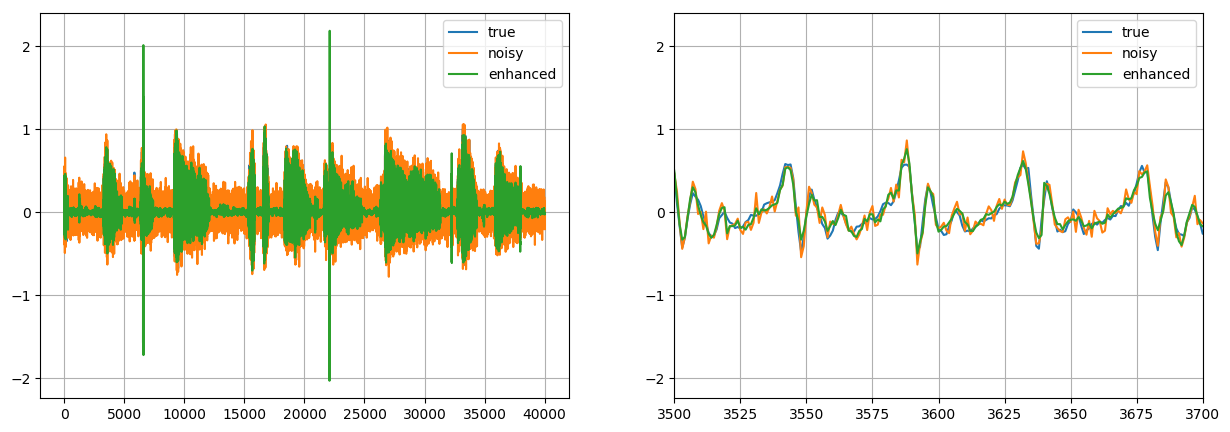

In [21]:
# plot signals
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(y_speech_true, label="true")
ax[1].plot(y_speech_n, label="noisy")
ax[1].plot(y_enhanced, label="enhanced")
ax[2].plot(y_speech_true, label="true")
ax[2].plot(y_speech_n, label="noisy")
ax[2].plot(y_enhanced, label="enhanced")
ax[1].grid(), ax[2].grid(), ax[2].set_xlim([3500, 3700]), ax[1].legend(), ax[2].legend()
audioplayers(y_speech_true, y_speech_n, y_enhanced, fs=fs)

In [22]:
mean(abs2.(y_speech_true - y_speech_n)), mean(abs2.(y_speech_true - y_enhanced))

(0.010026361330788944, 0.005554848126970516)